In [332]:
import numpy as np
import cvxpy as cp
import scipy as sp
import matplotlib.pyplot as plt

from tqdm import tqdm

%matplotlib inline

### Initalize some prameters

In [374]:
N   = 300
M0  = 50
M   = 1024

f = np.zeros(M)
f[:M0] = np.random.randn(M0)
np.random.shuffle(f)
f[f > 0] = 1
f[f < 0] = -1
sig_list = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5]

### Decide $w_{ii}$

In [390]:
w = 1
B = np.random.randn(N, M)
U = sp.linalg.orth(B)
V = sp.linalg.orth(B.T)
W = np.diag(w * np.ones((N,)))
# W = w * np.diag(np.random.randn(N))
A = U @ W @ V.T 
tot = 0
for i in range(10000):
    x = np.random.randn(300)
    tot += np.linalg.norm(f) / np.linalg.norm(A @ f)
print(tot / 10000)

1.8161194184301919


In [391]:
w = 1.8
B = np.random.randn(N, M)
U = sp.linalg.orth(B)
V = sp.linalg.orth(B.T)
W = np.diag(w * np.ones((N,)))
# W = w * np.diag(np.random.randn(N))
A = U @ W @ V.T 

### Functions

In [340]:
def prepare_data(N, M0, M, w, sig):

    eps = np.sqrt(sig * sig * (N + 2 * np.sqrt(2 * N)))

    e = sig * np.random.randn(N)

    u, s, vh = np.linalg.svd(A, full_matrices=False)
    s = np.exp(-s / 100)
    As = (u * s) @ vh

    return eps, f, A, As, e

def compress(x, A):
    return A @ x

def compress_with_noise(x, A, e):
    return A @ x + e

def show_signal(f):
    
    plt.figure(figsize=(10, 6))
    x_axis = range(0, f.shape[0])
    f_min = np.min(f)
    f_max = np.max(f)
    ylim = np.max(np.abs([f_min, f_max])) + 0.2
    plt.vlines(x_axis, np.zeros(f.shape[0]), f)
    plt.hlines(0, 0, f.shape[0], color='black', linewidth=1)
    plt.ylim(-ylim, ylim)
    plt.show()   

def show_signal_subplot(f, fig):
    
    x_axis = range(0, f.shape[0])
    f_min = np.min(f)
    f_max = np.max(f)
    ylim = np.max(np.abs([f_min, f_max])) + 0.2
    fig.vlines(x_axis, np.zeros(f.shape[0]), f)
    fig.hlines(0, 0, f.shape[0], color='black', linewidth=1)
    fig.axis(ymin=-ylim,ymax=ylim)

def show_res(res, idx):
    ri = res[idx]
    fig, ax = plt.subplots(3, 2, figsize=(20, 15))
    show_signal_subplot(ri['f'], ax[0, 0])
    show_signal_subplot(ri['f'], ax[0, 1])
    show_signal_subplot(ri['f_bp'], ax[1, 0])
    show_signal_subplot(ri['f_bp_As'], ax[1, 1])
    show_signal_subplot(ri['f_bpde'], ax[2, 0])
    show_signal_subplot(ri['f_bpde_As'], ax[2, 1])
    
def cal_res(res, idx):
    ri = res[idx]
    print("sig:", ri['sig'])
    print("eps: %.4f" % ri['eps'])
    print("||f-f_bp||2: %.4e" % np.linalg.norm(ri['f'] - ri['f_bp']))
    print("||f-f_bp_As||2: %.4e" % np.linalg.norm(ri['f'] - ri['f_bp_As']))
    print("||f-f_bpde||2: %.4e" % np.linalg.norm(ri['f'] - ri['f_bpde']))
    print("||f-f_bpde_As||2: %.4e" % np.linalg.norm(ri['f'] - ri['f_bpde_As']))
    print("------------------------------")

def basis_pursuit(f, A):
    
    y = compress(f, A)
    x = cp.Variable(M)
    prob = cp.Problem(cp.Minimize(cp.atoms.norm1(x)), 
                    [A @ x == y])
    prob.solve()

    return y, x.value

def basis_pursuit_de_noising(f, A, e, eps):
    
    y = compress_with_noise(f, A, e)
    x = cp.Variable(M)
    prob = cp.Problem(cp.Minimize(cp.atoms.norm1(x)), 
                    [cp.atoms.norm(A @ x - y, p=2) <= eps])
    prob.solve()

    return y, x.value

### Run the results

In [392]:
res = []
for sig in tqdm(sig_list):
    eps, f, A, As, e = prepare_data(N, M0, M, 1, sig)
    y_bp, f_bp = basis_pursuit(f, A)
    y_bp_As, f_bp_As = basis_pursuit(f, As)
    y_bpde, f_bpde = basis_pursuit_de_noising(f, A, e, eps)
    y_bpde_As, f_bpde_As = basis_pursuit_de_noising(f, As, e, eps)
    res.append({
        'w': 1,
        'sig': sig,
        'eps': eps,
        'f': f,
        'A': A,
        'As': As, 
        'e': e,
        'f_bp': f_bp,
        'y_bp': y_bp,
        'f_bp_As': f_bp_As,
        'y_bp_As': y_bp_As,
        'f_bpde': f_bpde,
        'y_bpde': y_bpde,
        'f_bpde_As': f_bpde_As,
        'y_bpde_As': y_bpde_As,
    })

100%|██████████| 6/6 [00:19<00:00,  3.27s/it]


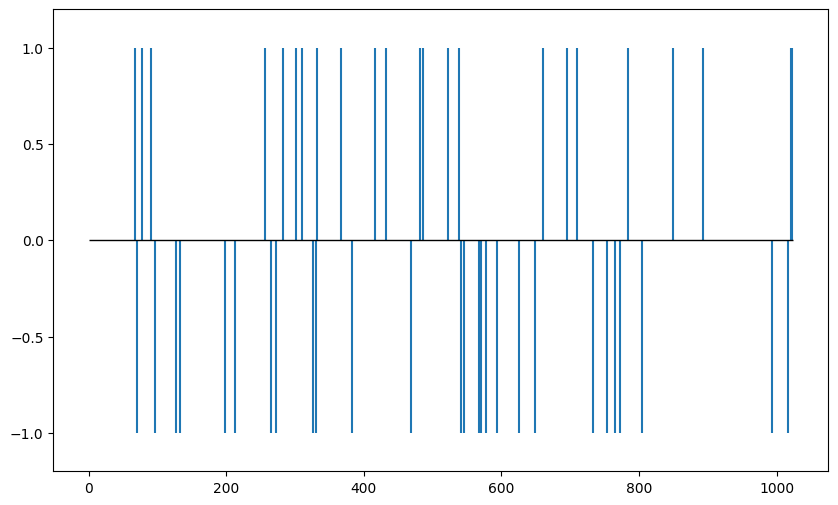

In [398]:
show_signal(res[0]['f_bp'])

In [405]:
for i in range(len(res)):
    cal_res(res, i)

sig: 0.01
eps: 0.1868
||f-f_bp||2: 1.7314e-09
||f-f_bp_As||2: 1.7314e-09
||f-f_bpde||2: 3.0605e-01
||f-f_bpde_As||2: 5.6090e-01
------------------------------
sig: 0.02
eps: 0.3736
||f-f_bp||2: 1.7314e-09
||f-f_bp_As||2: 1.7314e-09
||f-f_bpde||2: 6.0347e-01
||f-f_bpde_As||2: 1.1060e+00
------------------------------
sig: 0.05
eps: 0.9341
||f-f_bp||2: 1.7314e-09
||f-f_bp_As||2: 1.7314e-09
||f-f_bpde||2: 1.4325e+00
||f-f_bpde_As||2: 2.6254e+00
------------------------------
sig: 0.1
eps: 1.8681
||f-f_bp||2: 1.7314e-09
||f-f_bp_As||2: 1.7314e-09
||f-f_bpde||2: 2.7346e+00
||f-f_bpde_As||2: 4.6398e+00
------------------------------
sig: 0.2
eps: 3.7363
||f-f_bp||2: 1.7314e-09
||f-f_bp_As||2: 1.7314e-09
||f-f_bpde||2: 4.8244e+00
||f-f_bpde_As||2: 6.2175e+00
------------------------------
sig: 0.5
eps: 9.3406
||f-f_bp||2: 1.7314e-09
||f-f_bp_As||2: 1.7314e-09
||f-f_bpde||2: 6.6857e+00
||f-f_bpde_As||2: 7.0711e+00
------------------------------


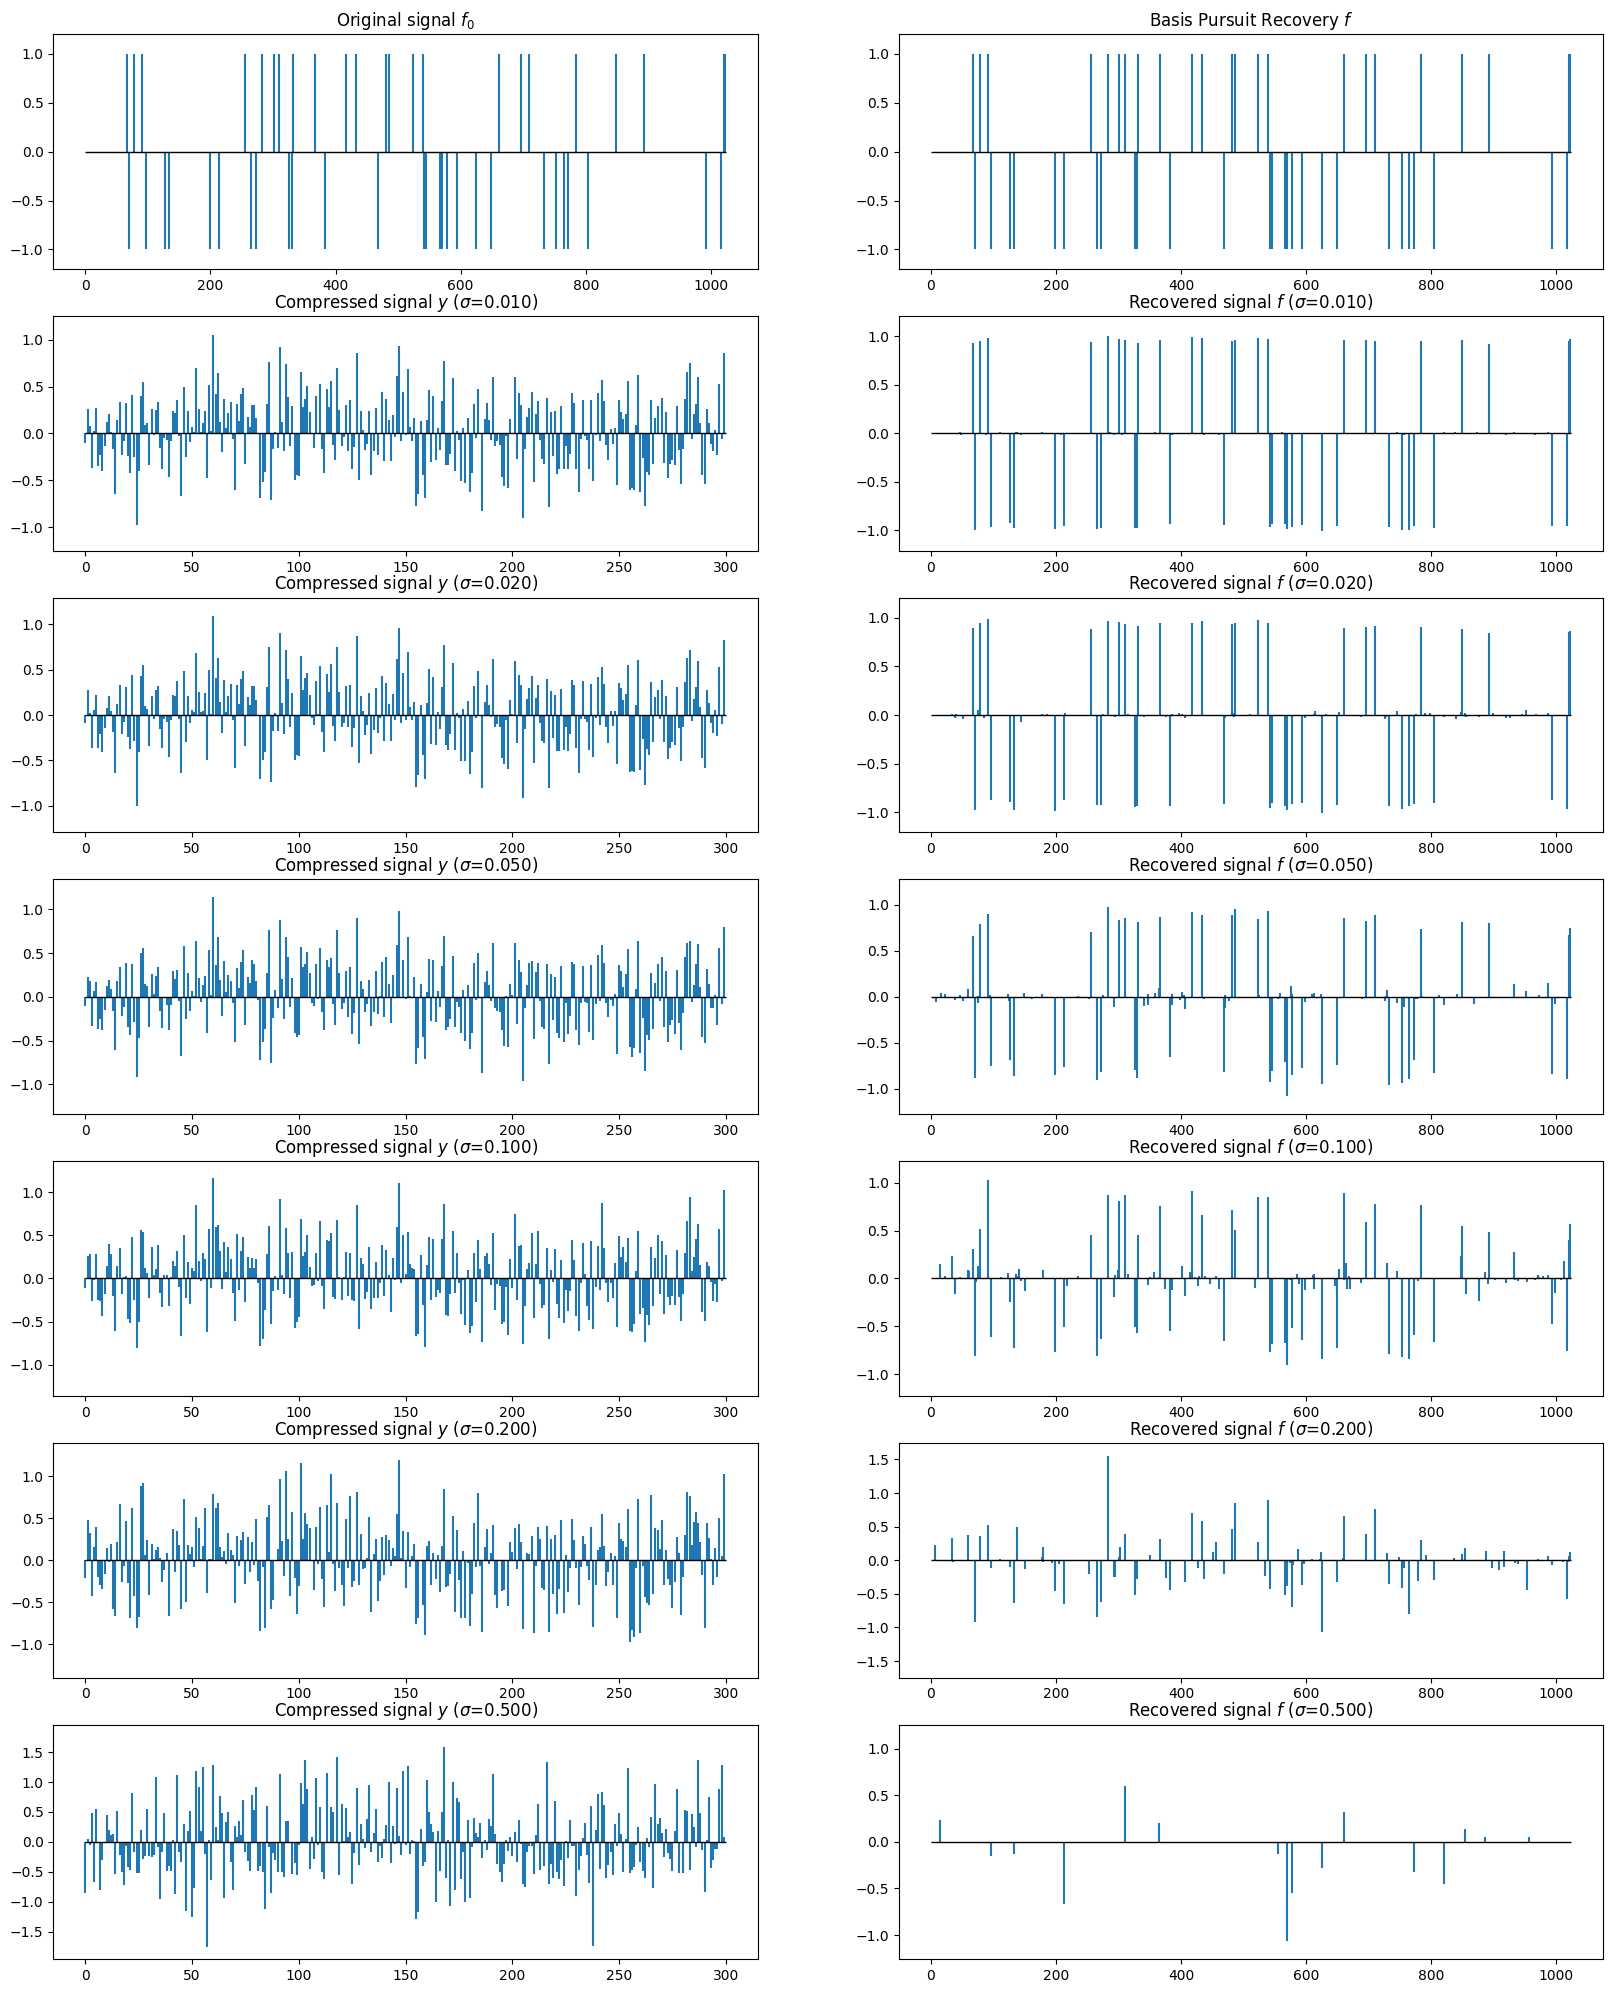

In [407]:
fig, ax = plt.subplots(len(res) + 1, 2, figsize=(20, 25))
show_signal_subplot(res[0]['f'], ax[0, 0])
ax[0, 0].set_title('Original signal $f_0$')
show_signal_subplot(res[0]['f_bp'], ax[0, 1])
ax[0, 1].set_title('Basis Pursuit Recovery $f$')
for i in range(len(res)):
    ri = res[i]
    show_signal_subplot(ri['y_bpde'], ax[i + 1, 0])
    ax[i + 1, 0].set_title('Compressed signal $y$ ($\sigma$=%.3f)' % ri['sig'])
    show_signal_subplot(ri['f_bpde'], ax[i + 1, 1])
    ax[i + 1, 1].set_title('Recovered signal $f$ ($\sigma$=%.3f)' % ri['sig'])

Text(0.5, 1.0, 'Basis Pursuit De-Noising Recovery with Singular Spectrum of $A$ Changed')

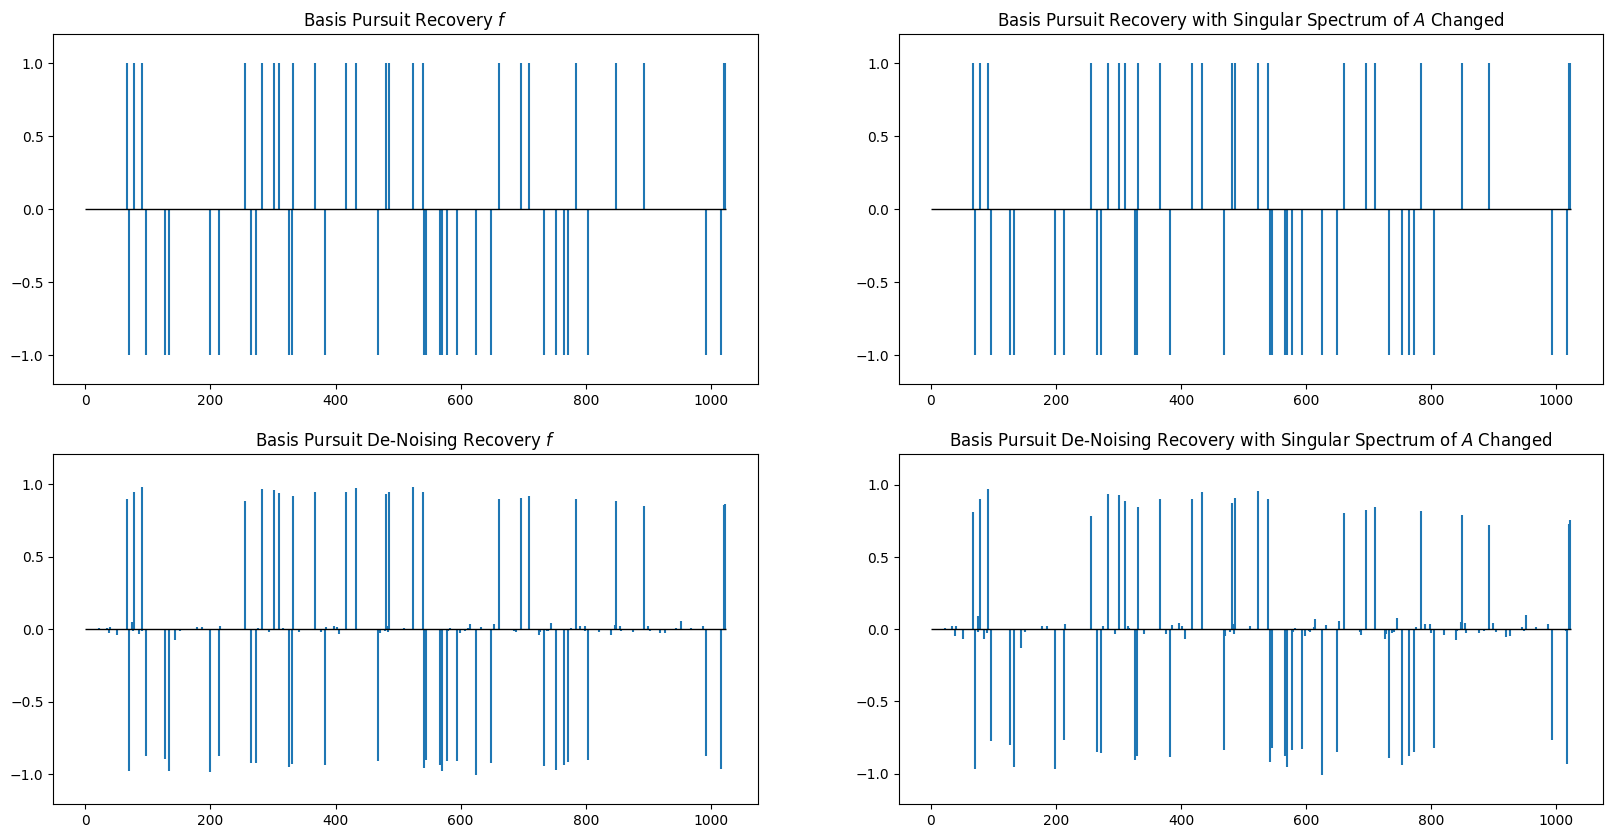

In [404]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))

show_signal_subplot(res[1]['f_bp'], ax[0, 0])
ax[0, 0].set_title('Basis Pursuit Recovery $f$')
show_signal_subplot(res[1]['f_bp_As'], ax[0, 1])
ax[0, 1].set_title('Basis Pursuit Recovery with Singular Spectrum of $A$ Changed')

show_signal_subplot(res[1]['f_bpde'], ax[1, 0])
ax[1, 0].set_title('Basis Pursuit De-Noising Recovery $f$')
show_signal_subplot(res[1]['f_bpde_As'], ax[1, 1])
ax[1, 1].set_title('Basis Pursuit De-Noising Recovery with Singular Spectrum of $A$ Changed')